# Frequentism, Samples and the Bootstrap

Based on: https://github.com/cs109/2015lab3/blob/master/Lab3-Freq.ipynb

In [2]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

Forty-four babies -- a new record -- were born in one 24-hour period at the Mater Mothers' Hospital in Brisbane, Queensland, Australia, on December 18, 1997. For each of the 44 babies, The Sunday Mail recorded the time of birth, the sex of the child, and the birth weight in grams. Also included is the number of minutes since midnight for each birth.

Columns
  * 1 -  8  Time of birth recorded on the 24-hour clock
  * 9 - 16  Sex of the child (1 = girl, 2 = boy)
  * 17 - 24  Birth weight in grams
  * 25 - 32  Number of minutes after midnight of each birth

In [4]:
df = pd.read_table("2015lab3/babyboom.dat.txt", header=None, sep='\s+', 
                   names=['24hrtime','sex','weight','minutes'])
df.head()

,24hrtime,sex,weight,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


In [6]:
df.describe()

,24hrtime,sex,weight,minutes
count,44.000000,44.000000,44.000000,44.000000
mean,1296.000000,1.590909,3275.954545,788.727273
std,690.704561,0.497350,528.032458,416.066931
min,5.000000,1.000000,1745.000000,5.000000
25%,792.750000,1.000000,3141.500000,482.750000
50%,1406.500000,2.000000,3404.000000,846.500000
75%,1918.500000,2.000000,3571.750000,1158.500000
max,2355.000000,2.000000,4162.000000,1435.000000


In [7]:
df.corr()

,24hrtime,sex,weight,minutes
24hrtime,1.000000,0.028027,0.075636,0.999840
sex,0.028027,1.000000,0.228751,0.031815
weight,0.075636,0.228751,1.000000,0.079616
minutes,0.999840,0.031815,0.079616,1.000000


AWESOME

Let's split the two 

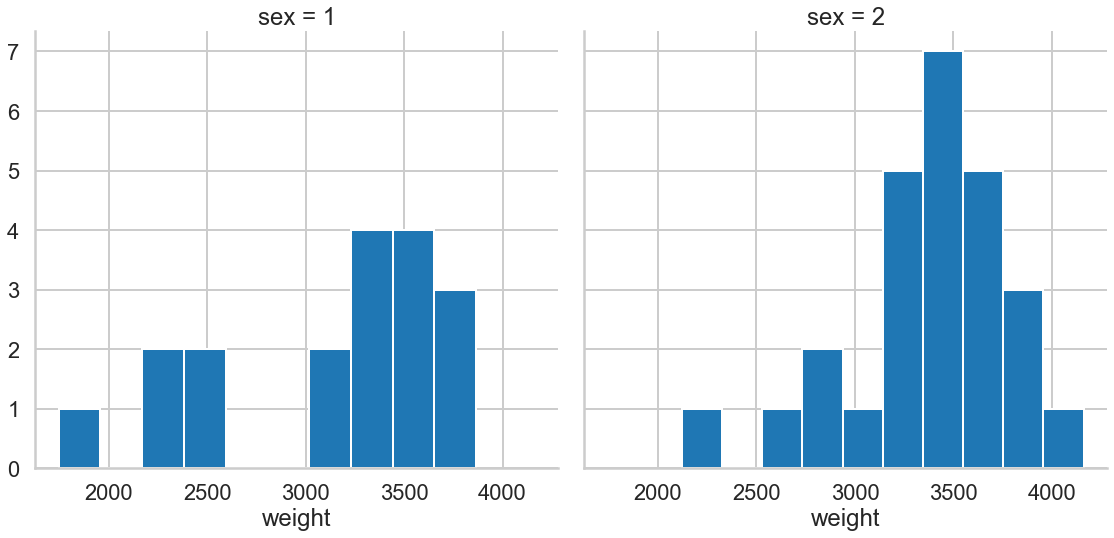

In [9]:
g = sns.FacetGrid(col="sex", data=df, height=8) 
g.map(plt.hist, "weight")

This is cool! More detail on what we've done can be found here: https://seaborn.pydata.org/tutorial/axis_grids.html

TLDR: the facetgrid creates the two axes, and then the map plots data onto this

**SUMMARY**: Frequentist Statistics treats data as a sample from an existing population.

There's a lot more detail to be found in the source material, but for now we'll focus on the current dataset:

### Understanding our data using a distribution 

The first birth occured at 5mins past midnight, and the last at 2355 - giving us a 1430 min period for 43 births

I.e. we would expect a 33.26min gap between births - let's histogram this!

count     43.000000
mean      33.255814
std       29.561150
min        1.000000
25%       14.000000
50%       27.000000
75%       46.000000
max      157.000000
Name: minutes, dtype: float64

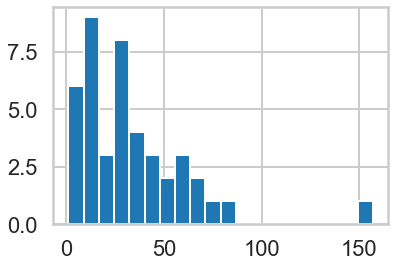

In [11]:
timediffs = df.minutes.diff()[1:]
timediffs.hist(bins = 20)
timediffs.describe()

#### Some stats notes:


The mean or of an exponentially distributed random variable X with rate parameter $\lambda$ can be analytically calculated as

$$Ex[X] = \frac{1}{\lambda}.$$
This makes intuitive sense: if you get babies at an average rate of 2 per hour, then you can expect to wait half an hour for every baby.

The variance of X is given by

$$Var[X] = \frac{1}{\lambda^2}.$$

In [14]:
lambda_from_mean = 1./timediffs.mean()
print(lambda_from_mean), print(1./lambda_from_mean)

0.03006993006993007
33.25581395348837


(None, None)

In [17]:
minutes = np.arange(0, 165, 5)
print(minutes)

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160]


In [25]:
rv = stats.expon(scale=1./lambda_from_mean)
type(rv)

scipy.stats._distn_infrastructure.rv_frozen

From here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html

*'A common parameterization for expon is in terms of the rate parameter lambda, such that pdf = lambda * exp(-lambda * x). This parameterization corresponds to using scale = 1 / lambda.'*

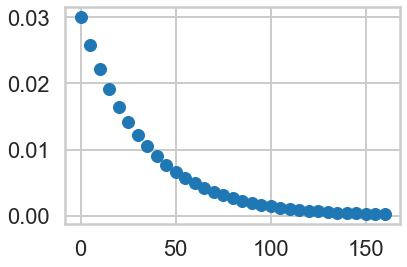

In [26]:
plt.plot(minutes,rv.pdf(minutes),'o')

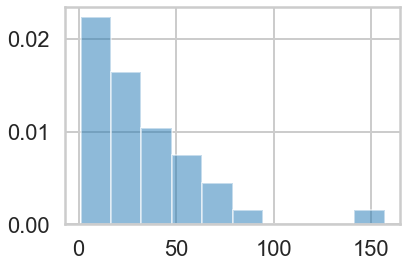

In [28]:
timediffs.hist(density=True, alpha=0.5);

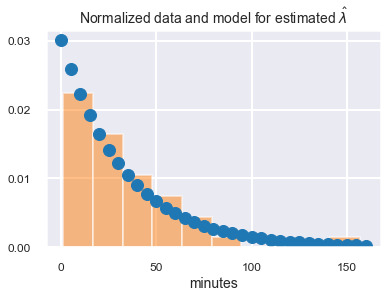

In [38]:
with sns.axes_style('darkgrid'):
    plt.plot(minutes,rv.pdf(minutes),'o')
    timediffs.hist(density=True, alpha=0.5);
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("minutes", fontsize = 14);
    plt.title("Normalized data and model for estimated $\hat{\lambda}$", fontsize = 14);

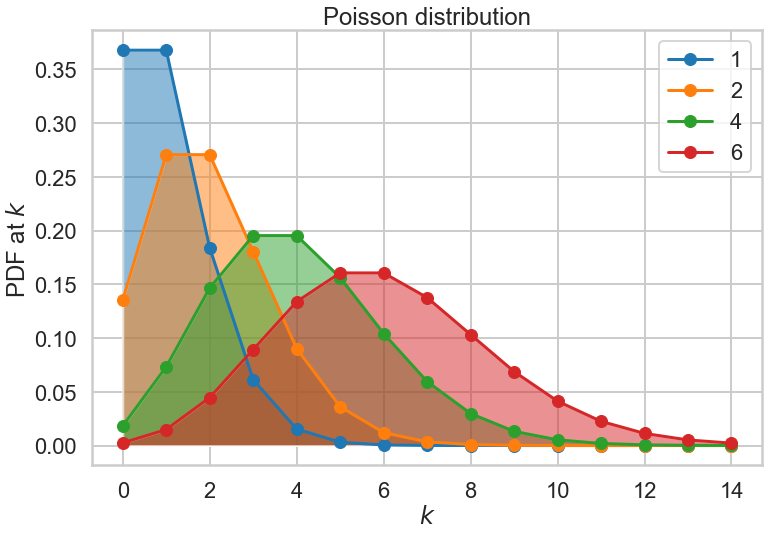

In [40]:
from scipy.stats import poisson
k = np.arange(15)
plt.figure(figsize=(12,8))
for i, lambda_ in enumerate([1, 2, 4, 6]):
    plt.plot(k, poisson.pmf(k, lambda_), '-o', label=lambda_)
    plt.fill_between(k, poisson.pmf(k, lambda_), alpha=0.5)
    plt.legend()
plt.title("Poisson distribution")
plt.ylabel("PDF at $k$")
plt.xlabel("$k$");

I find this very interesting, showing how the Poisson distribution is affected by changes in the 'rate' parameter (lambda)

In [42]:
per_hour = df.minutes // 60 ## 'floor division' - rounds down to the nearest number
num_births_per_hour = df.groupby(per_hour).minutes.count()
num_births_per_hour

minutes
0     1
1     3
2     1
4     4
7     2
8     2
9     1
10    3
11    1
12    2
13    1
14    4
15    1
16    2
17    1
18    3
19    4
20    3
21    2
22    1
23    2
Name: minutes, dtype: int64

In [43]:
num_births_per_hour.mean()

2.0952380952380953

Text(0, 0.5, 'rate')

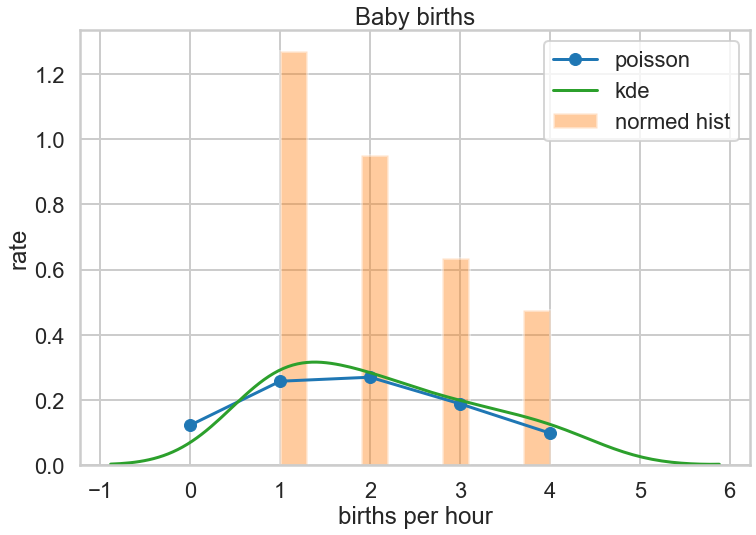

In [48]:
k = np.arange(5)
plt.figure(figsize=(12,8))
plt.plot(k, poisson.pmf(k, num_births_per_hour.mean()), '-o', label = 'poisson')
plt.hist(num_births_per_hour, alpha=0.4,  lw=3, density = True, label = 'normed hist')
sns.kdeplot(num_births_per_hour, label="kde")
plt.title("Baby births")
plt.xlabel("births per hour")
plt.ylabel("rate")

KDE Plot detail here: https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/ (I don't know why this is here but hey)

The density flag doesn't normalise it to a pdf - in order to do this we need to equally weight the values:

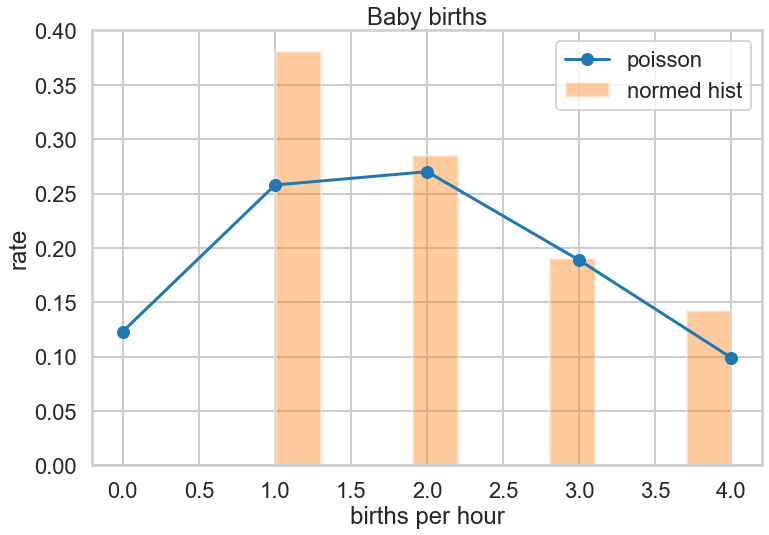

In [55]:
k = np.arange(5)
weights = np.ones_like(num_births_per_hour)/float(len(num_births_per_hour))
plt.figure(figsize=(12,8))
plt.plot(k, poisson.pmf(k, num_births_per_hour.mean()), '-o', label = 'poisson')
plt.hist(num_births_per_hour, alpha=0.4,  lw=3, density = True, label = 'normed hist')
plt.title("Baby births")
plt.xlabel("births per hour")
plt.ylabel("rate")
plt.legend()

In [53]:
weights

array([0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905])

### Inference

Just having an estimate is no good. We will want to put confidence intervals on the estimation of the parameters. This presents a conundrum: we have access to only one sample, but want to compute a error estimate over multiple samples, using an estimator such as the standard deviation.

In the last two decades, resampling the ONE dataset we have has become computationally feasible. Resampling involves making new samples from the observations, each of which is analysed in the same way as out original dataset. One way to do this is the Bootstrap.

#### Bootstrap:

**Bootstrap tries to approximate our sampling distribution.**

We generate these samples, using the parameter we calculated. Or, alteratively, we sample with replacement the X from our original sample D, generating many fake datasets, and then compute the distribution on the parameters as before.

##### Non Parametric bootstrap:
Resample the data! We can then plot the distribution of the mean time-difference.

In [56]:
M_samples = 10000
N_points = timediffs.shape[0]
N_points

43

In [60]:
bs_np = np.random.choice(timediffs, size=(M_samples, N_points))
bs_np

array([[ 14.,   2.,   4., ...,  15.,  27.,  70.],
       [  2.,  18.,  45., ...,  27.,  70.,  27.],
       [ 28.,  77.,  28., ...,  26.,   2.,  27.],
       ...,
       [ 14.,  27.,  13., ...,  37.,  26.,  25.],
       [ 15.,  40.,  47., ...,  59.,  86.,   1.],
       [ 27., 157.,  47., ...,   1.,  15.,  28.]])

In [66]:
sd_mean = np.mean(bs_np, axis=1)
print(sd_mean)
sd_std = np.std(bs_np, axis=1)
print(sd_std)

[30.13953488 39.8372093  35.81395349 ... 30.93023256 38.97674419
 39.1627907 ]
[18.8489484  29.9347587  40.01700558 ... 20.69984311 33.82546747
 33.07984016]


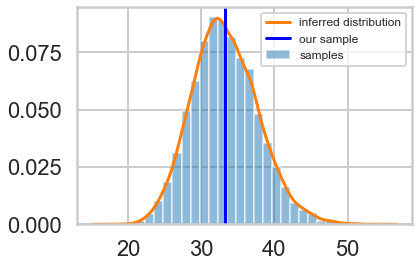

In [73]:
plt.hist(sd_mean, bins=30, density=True, alpha=0.5,label="samples");
sns.kdeplot(sd_mean, label="inferred distribution")
plt.axvline(timediffs.mean(), color='b', label='our sample')
plt.legend(fontsize = 12)

##### Parametric bootstrap:
And here we do it in a parametric way. We get an "estimate" of the parameter from our sample, and them use the exponential distribution to generate many datasets, and then fir the parameter on each one of those datasets. We can then plot the distribution of the mean time-difference.

Translated: we start from the poisson distribution and build backwards 

In [83]:
rv = stats.expon(scale=1./lambda_from_mean)
M_samples=10000
N_points = timediffs.shape[0]
bs_p = rv.rvs(size=(M_samples, N_points))
bs_p

array([[ 2.19864356, 31.01265855, 50.25949085, ..., 12.66844883,
        15.98592045, 33.53798729],
       [ 1.9662391 , 33.46546227,  8.48738881, ..., 17.25719568,
        48.76214231, 13.84884658],
       [11.55114687, 45.98274969, 33.47309832, ..., 14.22343161,
        23.43805796, 14.77156643],
       ...,
       [80.70179398, 26.58848734,  9.08717609, ...,  0.1103511 ,
        74.68485056, 42.18644013],
       [ 0.1734435 , 85.01444143, 36.21035645, ..., 18.49821413,
        57.95595235, 24.98595044],
       [61.27140132, 11.02859364, 17.81329391, ..., 82.43147908,
        52.72558739, 27.99525527]])

Notice how these are floats as they have been selected from the exponential distribution!

In [85]:
sd_mean_p=np.mean(bs_p, axis=1)
print(sd_mean_p)
sd_std_p=np.std(bs_p, axis=1)
print(sd_std_p)

[30.32512152 28.38254455 25.96366506 ... 32.24809344 32.75410731
 36.96995531]
[30.20628981 27.1643346  26.9742238  ... 27.43373883 30.84647282
 39.19279969]


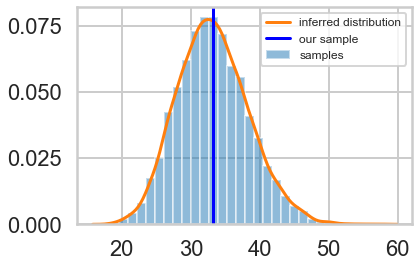

In [87]:
plt.hist(sd_mean_p, bins=30, density=True, alpha=0.5,label="samples");
sns.kdeplot(sd_mean_p, label="inferred distribution")
plt.axvline(timediffs.mean(), color='b', label='our sample')
plt.legend(fontsize = 12)

I'm not sure I fully understood the purpose of bootstrapping beyond approximation of sampling means and distribution. These were helpful:
* https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/
* https://stats.stackexchange.com/questions/26088/explaining-to-laypeople-why-bootstrapping-works (this was especially good)

My first thought was that you don't need to sample if you're comfortable with assumptions of the shape of your distribution. However, as this second link mentions this requries particularly convenient assumptions.